# Burchardt and Knörnschild (2020) <br/> **Bats and sperm whales**

**Reference:** Burchardt LS, Knörnschild M (2020) Comparison of methods for rhythm analysis of complex animals’ acoustic signals. PLoS Comput Biol 16(4): e1007755. https://doi.org/10.1371/journal.pcbi.1007755

**Dataset:** https://doi.org/10.1371/journal.pcbi.1007755.s006

**Copyright**: © 2020 Burchardt, Knörnschild. This is an open access article distributed under the terms of the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original author and source are credited.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.intervals import save_intervals, load_intervals
from src.motifs import ngram_motifs, normalize
from src.plotting import ternary_motif_plot

## Preprocessing



I manually exported the three tables in the excel file to three csv files. 

- `carollia-perspicillata.csv` contains the table `IOI C.persp`
- `saccopteryx-bilineata.csv` contains the table `IOI S.bil`
- `sperm-whale-physeter-macrocephalus.csv` contains the table `IOI P .mac1`

Each file contains the IOIs of the respective species in two columns. The first 
column (`IOI`) gives IOIs (Inter-Onset-Inntervals) **in seconds**. The second
column indicates the raw datafile.

From the datafile one is able to recognize individuals as well as sequences.

- `C_persp_IC_p1_b1`: "These IOIs come from the bat Carollia perspicillata (C_persp). 
We are analysing Isolationcalls (IC) of Pup 1 (p1) and bout 1 (b1).	"
	
- `S_bil_IC_p21_2`: "These IOIs come from the bat Saccopteryx bilineata (S_bil). We are analysing Isolation Calls (IC) of Pup 21 (p21) and call 2 (2). The used data is a subset of a bigger dataset (see Knörnschild et al, 2012 or Burchardt et al, 2019)."
- `sw114a002_coda_01.xls`: "These IOIs come from the Sperm whale Physeter macrocephalus (sw). The coda sequences are taken out of the original datafile sw114a002, which codes the individual (sw114a) and number of datafile of the recording day (002). The data was collected by the Dominican Sperm Whale Project."
	
	
Literature

Knörnschild et al, 2012	Knörnschild M, Nagy M, Metz M, Mayer F, von Helversen O. Learned Vocal Group Signatures in the Polygynous Bat Saccopteryx Bilineata. Animal Behaviour. 2012;84:761-9, doi: 10.1016/j.anbehav.2012.06.029

Burchardt et al, 2019	Burchardt LS, Norton P, Behr O, Scharff C, Knörnschild M. General Isochronous Rhythm in Echolocation Calls and Social Vocalizations of the Bat Saccopteryx Bilineata. Royal Society Open Science. 2019;6, doi: 10.1098/rsos.181076.

### Carollia perspicillata

In [2]:
# Carollia perspicillata
path = 'data/burchardt-knornschild2020/bat-carollia-perspicillata.csv'
carollia = pd.read_csv(path, delimiter=';', decimal=',').iloc[:, :2]
carollia.columns = ['ioi', 'datafile']
carollia['species'] = 'Carollia perspicillata'

# Parse data file name
parts = carollia.datafile.str.replace('C_persp_', '').str.split('_')
parts = pd.DataFrame([p for p in parts.values])
carollia['call_type'] = parts[0]
carollia['individual'] = parts[1].str.replace('p', '').astype(int)
carollia['bout'] = parts[2].str.replace('b', '').astype(int)

# carollia.to_csv('intervals/burchardt-knornschild2020/bat-carollia-perspicillata-data.csv')

In [3]:
intervals = []
for _, (indiv, bout) in carollia[['individual', 'bout']].drop_duplicates().iterrows():
    subset = carollia.query(f'individual=={indiv} and bout=={bout}')
    intervals.extend(subset['ioi'])
    intervals.append(np.nan)

# save_intervals(intervals, 'burchardt-knornschild2020', 'bat-carollia-perspicillata')

### Saccopteryx bilineata

In [4]:
# Saccopteryx bilineata
path = 'data/burchardt-knornschild2020/bat-saccopteryx-bilineata.csv'
saccopteryx = pd.read_csv(path, delimiter=';', decimal=',').iloc[:, :2]
saccopteryx.columns = ['ioi', 'datafile']
saccopteryx['species'] = 'Saccopteryx bilineata'

# Parse data file name
parts = saccopteryx.datafile.str.replace('S_bil_', '').str.split('_')
parts = pd.DataFrame([p for p in parts.values])
saccopteryx['call_type'] = parts[0]
saccopteryx['individual'] = parts[1].str.replace('p', '').astype(int)
saccopteryx['call'] = [int(i) for i in parts[2]]

# saccopteryx.to_csv('intervals/burchardt-knornschild2020/bat-saccopteryx-bilineata-data.csv')

In [5]:
intervals = []
for _, (indiv, call) in saccopteryx[['individual', 'call']].drop_duplicates().iterrows():
    subset = saccopteryx.query(f'individual=={indiv} and call=={call}')
    intervals.extend(subset['ioi'])
    intervals.append(np.nan)

# save_intervals(intervals, 'burchardt-knornschild2020', 'bat-saccopteryx-bilineata')

### Physeter macrocephalus

In [6]:
# Physeter macrocephalus
path = 'data/burchardt-knornschild2020/whale-physeter-macrocephalus.csv'
whale = pd.read_csv(path, delimiter=';', decimal=',').iloc[:, :2]
whale.columns = ['ioi', 'datafile']
whale['species'] = 'Physeter macrocephalus'

# Parse data file name
whale['individual'] = whale['datafile'].str[:6]
whale['coda'] = [int(coda) for coda in whale['datafile'].str[-6:-4]]
whale['datafile_num'] = whale['datafile'].str[6:9]

# whale.to_csv('intervals/burchardt-knornschild2020/whale-physeter-macrocephalus-data.csv')

In [7]:
# There is only one individual
assert len(whale['individual'].unique()) == 1
indiv_id = whale['individual'].unique()[0]
assert (whale['individual'] == indiv_id).all()

intervals = []
for coda in whale['coda'].unique():
    subset = whale.query(f'coda=={coda}')
    intervals.extend(subset['ioi'])
    intervals.append(np.nan)

# save_intervals(intervals, 'burchardt-knornschild2020', 'whale-physeter-macrocephalus')

## Plot

In [8]:
whale_intervals = load_intervals('burchardt-knornschild2020', 'whale-physeter-macrocephalus')
carollia_intervals = load_intervals('burchardt-knornschild2020', 'bat-carollia-perspicillata')
saccopteryx_intervals = load_intervals('burchardt-knornschild2020', 'bat-saccopteryx-bilineata') 

Text(0.5, 1.0, 'Saccopteryx bilineata')

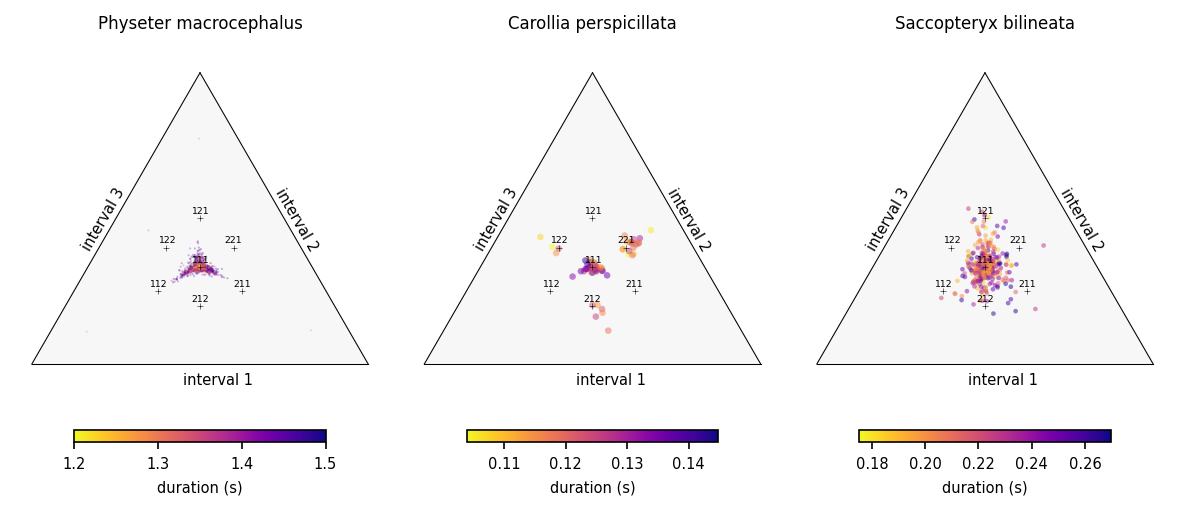

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.5), tight_layout=True)
kws = dict(ratio_kws=dict(factors=[1,2]), plot_kws=dict(bottom_label_offset=-.2))

motifs, duration = normalize(ngram_motifs(whale_intervals, length=3))
ternary_motif_plot(motifs, duration, min_dur=1.20, max_dur=1.50, ax=ax1, **kws)
ax1.set_title('Physeter macrocephalus', fontsize=8)

motifs, duration = normalize(ngram_motifs(carollia_intervals, length=3))
ternary_motif_plot(motifs, duration, ax=ax2, 
    scatter_kws=dict(s=10, alpha=.5), **kws)
ax2.set_title('Carollia perspicillata', fontsize=8)

motifs, duration = normalize(ngram_motifs(saccopteryx_intervals, length=3))
ternary_motif_plot(motifs, duration,  ax=ax3, 
    scatter_kws=dict(s=5, alpha=.5),  **kws)
ax3.set_title('Saccopteryx bilineata', fontsize=8)

# plt.savefig('figures/burchardt-knornschild2020/burchardt-knornschild2020-three-species.pdf')
# plt.savefig('figures/burchardt-knornschild2020/burchardt-knornschild2020-three-species.png', dpi=150)